In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
from torch_geometric.nn import BatchNorm
import matplotlib.pyplot as plt


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import sys
sys.path.append('/home/mei/nas/docker/thesis')
from dataloader.ts_reader import MultiModalDataset, collate_fn
from dataloader.pyg_reader import GraphDataset,graph_loader

In [4]:
class FlatFeatureEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FlatFeatureEncoder, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        return F.relu(self.fc(x))

In [23]:
class GraphEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GraphEncoder, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.bn1 = BatchNorm(hidden_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = F.relu(self.bn1(self.gcn1(x, edge_index)))
        x = self.dropout(x)
        x = self.gcn2(x, edge_index)
        return x    # shape = (num_nodes, hidden_dim)

In [6]:
class TimeSeriesEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(TimeSeriesEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out  

In [16]:
class RiskPredictor(nn.Module):
    def __init__(self, flat_dim, graph_dim, ts_dim, hidden_dim):
        super(RiskPredictor, self).__init__()
        self.fc1 = nn.Linear(flat_dim + graph_dim + ts_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, flat_emb, graph_emb, ts_emb):
        # Expand flat and graph embeddings to match time steps
        flat_emb_expanded = flat_emb.unsqueeze(1).expand(-1, ts_emb.size(1), -1)
        graph_emb_expanded = graph_emb.unsqueeze(1).expand(-1, ts_emb.size(1), -1)
        
        combined = torch.cat((flat_emb_expanded, graph_emb_expanded, ts_emb), dim=2)
        x = F.relu(self.fc1(combined))
        risk_score = torch.sigmoid(self.fc2(x)).squeeze(-1)  # Output shape: (batch_size, time_steps)
        return risk_score

In [28]:
class PatientOutcomeModel(nn.Module):
    def __init__(self, flat_input_dim, graph_input_dim, ts_input_dim, hidden_dim):
        super(PatientOutcomeModel, self).__init__()
        self.flat_encoder = nn.Linear(flat_input_dim, hidden_dim)  # Flat features encoder
        self.graph_encoder = GraphEncoder(graph_input_dim, hidden_dim)  # Graph GCN Encoder
        self.ts_encoder = TimeSeriesEncoder(ts_input_dim, hidden_dim)  # LSTM for Time-Series
        self.risk_predictor = RiskPredictor(hidden_dim, hidden_dim, hidden_dim * 2, hidden_dim)

    def forward(self, flat_data, graph_data, patient_ids, ts_data):
        """
        - flat_data:     (batch_size, D_flat)
        - graph_data:    (N_nodes, D_graph), edge_index
        - patient_ids:   (batch_size,)  -> 用于从 graph_data 里提取对应的节点
        - ts_data:       (batch_size, T, D_ts)
        """
        device = flat_data.device  # 统一所有 tensor 到这个 device
        edge_index = graph_data.edge_index.to(device)
        graph_x = graph_data.x.to(device)
        patient_ids = patient_ids.to(device)

        # === 计算整个图的 Graph Embeddings ===
        node_embeddings = self.graph_encoder(graph_x, edge_index)  # (N_nodes, D_graph)

        # === 确保 `graph_data.patient_ids` 也在相同设备上 ===
        graph_patient_ids = graph_data.patient_ids.to(device)  # ✅ 将 patient_ids 转移到 GPU

        # === 提取当前 batch 对应的 Graph Embeddings ===
        batch_indices = torch.tensor([torch.where(graph_patient_ids == pid)[0][0] for pid in patient_ids], dtype=torch.long, device=device)
        batch_graph_embeddings = node_embeddings[batch_indices]  # (batch_size, D_graph)

        # === 计算 Flat Embeddings ===
        flat_emb = self.flat_encoder(flat_data)  # (batch_size, D_flat)

        # === 计算 Time-Series Embeddings ===
        ts_emb = self.ts_encoder(ts_data)  # (batch_size, T, D_ts)

        # === 计算 Risk Scores ===
        risk_scores = self.risk_predictor(flat_emb, batch_graph_embeddings, ts_emb)

        return risk_scores



In [9]:
flat_input_dim = 104
graph_input_dim = 104
ts_input_dim = 162
hidden_dim = 128

In [10]:
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

config = {  
    "data_dir": "/home/mei/nas/docker/thesis/data/hdf",
    "graph_dir": "/home/mei/nas/docker/thesis/data/graphs",
    "mode": "k_closest",
    "k": 3         
}

In [11]:
# === LSTM + Flat Dataset ===
lstm_dataset_train = MultiModalDataset(train_data_dir)
lstm_dataset_val = MultiModalDataset(val_data_dir)
lstm_dataset_test = MultiModalDataset(test_data_dir)

lstm_loader_train = DataLoader(lstm_dataset_train , batch_size=32, shuffle=True, collate_fn=collate_fn)
lstm_loader_val = DataLoader(lstm_dataset_val , batch_size=32, shuffle=False, collate_fn=collate_fn)
lstm_loader_test = DataLoader(lstm_dataset_test , batch_size=32, shuffle=False, collate_fn=collate_fn)

# === Graph Dataset ===

graph_dataset = GraphDataset(config)


==> Loading precomputed graph from /home/mei/nas/docker/thesis/data/graphs/diagnosis_graph_k_closest_k3.pt
==> Loading flat features from /home/mei/nas/docker/thesis/data/hdf/final_flat.h5


In [25]:
def evaluate_model(model, lstm_loader, graph_dataset, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for patient_ids, ts_data, flat_data, risk_data in lstm_loader:
            ts_data, flat_data, risk_data = ts_data.to(device), flat_data.to(device), risk_data.to(device)

            # **获取 Graph Embeddings**
            patient_ids_tensor = torch.tensor([int(pid) for pid in patient_ids], dtype=torch.long, device=device)
            outputs = model(flat_data, graph_dataset.graph_data, patient_ids_tensor, ts_data)

            ts_mask = ts_data != -99
            ts_mask = ts_mask.any(dim=2)
            risk_mask = risk_data != -99
            combined_mask = ts_mask & risk_mask

            masked_outputs = outputs[combined_mask]
            masked_risk_data = risk_data[combined_mask]

            loss = criterion(masked_outputs, masked_risk_data)
            val_loss += loss.item()

    return val_loss / len(lstm_loader)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PatientOutcomeModel(flat_input_dim, graph_input_dim, ts_input_dim, hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss() 

In [32]:
num_epochs=10

train_losses = []
val_losses = []

best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for patient_ids, ts_data, flat_data, risk_data in lstm_loader_train:
        ts_data, flat_data, risk_data = ts_data.to(device), flat_data.to(device), risk_data.to(device)

        # **转换 patient_ids**
        patient_ids_tensor = torch.tensor([int(pid) for pid in patient_ids], dtype=torch.long, device=device)

        # === **前向传播** ===
        optimizer.zero_grad()
        outputs = model(flat_data, graph_dataset.graph_data, patient_ids_tensor, ts_data)

        # **应用 Mask 计算损失**
        ts_mask = ts_data != -99
        ts_mask = ts_mask.any(dim=2)
        risk_mask = risk_data != -99
        combined_mask = ts_mask & risk_mask

        masked_outputs = outputs[combined_mask]
        masked_risk_data = risk_data[combined_mask]

        loss = criterion(masked_outputs, masked_risk_data)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        torch.cuda.empty_cache()

    train_loss /= len(lstm_loader_train)
    train_losses.append(train_loss)

    # === 计算 Val Loss ===
    val_loss = evaluate_model(model, lstm_loader_val, graph_dataset, criterion, device)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


    # # 保存最佳模型
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     torch.save(model.state_dict(), 'best_model.pth')


Epoch 1/10, Train Loss: 0.0160, Val Loss: 0.0179
Epoch 2/10, Train Loss: 0.0157, Val Loss: 0.0180
Epoch 3/10, Train Loss: 0.0153, Val Loss: 0.0179
Epoch 4/10, Train Loss: 0.0146, Val Loss: 0.0177
Epoch 5/10, Train Loss: 0.0143, Val Loss: 0.0178
Epoch 6/10, Train Loss: 0.0137, Val Loss: 0.0178
Epoch 7/10, Train Loss: 0.0136, Val Loss: 0.0191
Epoch 8/10, Train Loss: 0.0130, Val Loss: 0.0184
Epoch 9/10, Train Loss: 0.0126, Val Loss: 0.0182
Epoch 10/10, Train Loss: 0.0121, Val Loss: 0.0179


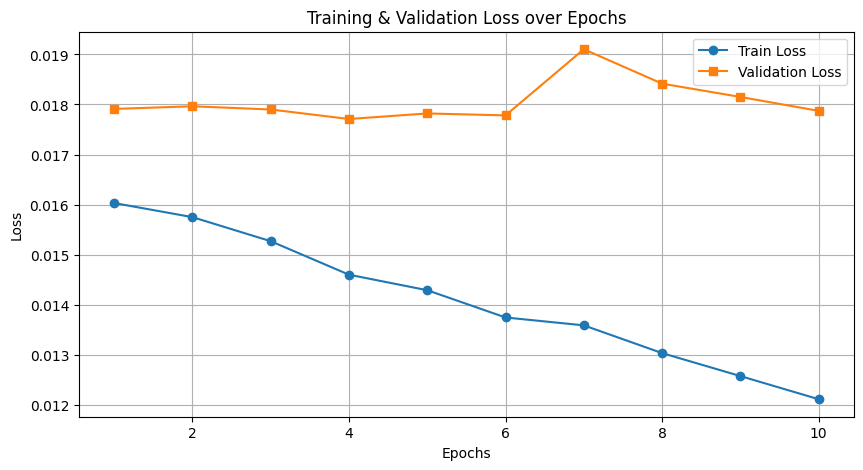

In [33]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss over Epochs")
plt.legend()
plt.grid()
plt.show()